<a href="https://colab.research.google.com/github/SabinaDDD/Play_market_apps/blob/main/googleplay_apps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'google-play-store-apps:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F49864%2F274957%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240312%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240312T121918Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc3cfc5fc21b0e30c1e32236f13fde8ec1733452143873b4763a5f04a82212319fdc1da6f83b21ae0aad238eeec474501ada66839156e9ab61285e51f392fceb4d2ba53f79cedbe31f05a92cad52fa67cdbafa1313fd6513211a8bec47e8750647faafba2db63fc04ee510e39f93c12b729eb232d3ab1fceca00fc4d2d78318e475349d85d41a38d7ee659d1dea1b461381dd52c7a728907496f555e59279a38a1d9df2059fd5a0a181d54bdef1f4a2d189eb93d1118b6183e95d3390a951c28596d1629ab1fb46bea2ed212afc45a1e7fc4f5e5e7ffd94508cd93b8040c8ce952e8c708f69e734389b44cc64190aabc4e19258e56e3e88606fe6533539b2df5e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2037893 bytes downloaded
Downloaded and uncompressed: google-play-store-apps
Data source import complete.


# Исследование данных по приложениям PlayMarket Google

In [2]:
import numpy as np # linear algebra
import pandas as pd #
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

    Загрузка и обзор данных

In [3]:
df = pd.read_csv("/kaggle/input/google-play-store-apps/googleplaystore.csv")# загрузка таблицы
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


     Очистка данных

In [5]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
df = df.dropna()
df.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

In [7]:
df.duplicated().sum()

474

In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

    Переведем некоторые столбцы к нужным типам данных, а для этого уберем лишние символы

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8886 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8886 non-null   object 
 1   Category        8886 non-null   object 
 2   Rating          8886 non-null   float64
 3   Reviews         8886 non-null   object 
 4   Size            8886 non-null   object 
 5   Installs        8886 non-null   object 
 6   Type            8886 non-null   object 
 7   Price           8886 non-null   object 
 8   Content Rating  8886 non-null   object 
 9   Genres          8886 non-null   object 
 10  Last Updated    8886 non-null   object 
 11  Current Ver     8886 non-null   object 
 12  Android Ver     8886 non-null   object 
dtypes: float64(1), object(12)
memory usage: 971.9+ KB


In [10]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [11]:
df['Price'] = df['Price'].apply(lambda x: x.replace('$',''))
df.Price = df.Price.astype(float)
df.Reviews = df.Reviews.astype(int)

In [12]:
df.Price.unique()

array([  0.  ,   4.99,   3.99,   6.99,   7.99,   5.99,   2.99,   3.49,
         1.99,   9.99,   7.49,   0.99,   9.  ,   5.49,  10.  ,  24.99,
        11.99,  79.99,  16.99,  14.99,  29.99,  12.99,   2.49,  10.99,
         1.5 ,  19.99,  15.99,  33.99,  39.99,   3.95,   4.49,   1.7 ,
         8.99,   1.49,   3.88, 399.99,  17.99, 400.  ,   3.02,   1.76,
         4.84,   4.77,   1.61,   2.5 ,   1.59,   6.49,   1.29, 299.99,
       379.99,  37.99,  18.99, 389.99,   8.49,   1.75,  14.  ,   2.  ,
         3.08,   2.59,  19.4 ,   3.9 ,   4.59,  15.46,   3.04,  13.99,
         4.29,   3.28,   4.6 ,   1.  ,   2.95,   2.9 ,   1.97,   2.56,
         1.2 ])

In [13]:
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', ''))
df['Installs'] = df['Installs'].apply(lambda x: x.replace(',', ''))
df['Installs'] = df['Installs'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8886 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             8886 non-null   object 
 1   Category        8886 non-null   object 
 2   Rating          8886 non-null   float64
 3   Reviews         8886 non-null   int64  
 4   Size            8886 non-null   object 
 5   Installs        8886 non-null   int64  
 6   Type            8886 non-null   object 
 7   Price           8886 non-null   float64
 8   Content Rating  8886 non-null   object 
 9   Genres          8886 non-null   object 
 10  Last Updated    8886 non-null   object 
 11  Current Ver     8886 non-null   object 
 12  Android Ver     8886 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1.2+ MB


In [14]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


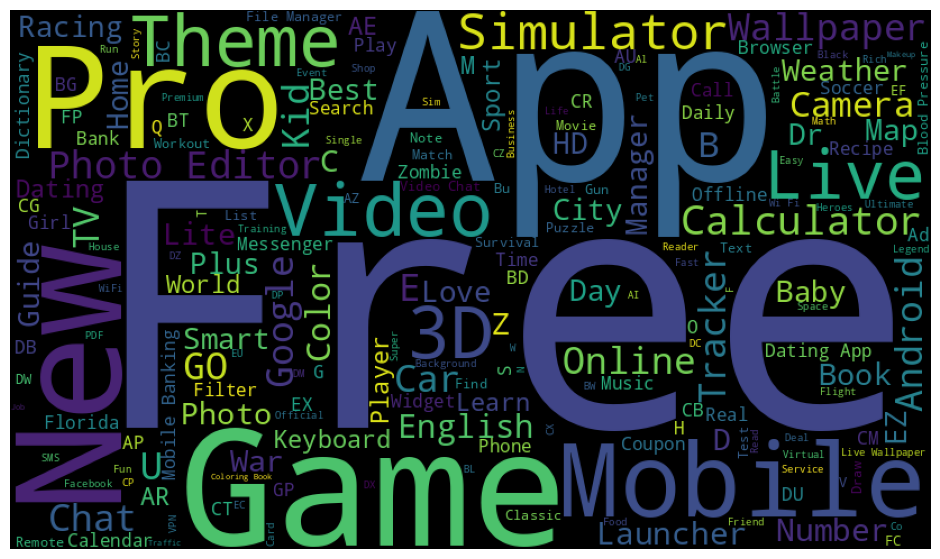

In [15]:
plt.subplots(figsize=(12,7))
wordcloud = WordCloud(
                          background_color='black',
                          width=820,
                          height=480
                         ).generate(" ".join(df.App))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<ipython-input-16-3b381c391505>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.countplot(data = df, x= df['Category'], palette = "Set1")
<ipython-input-16-3b381c391505>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")


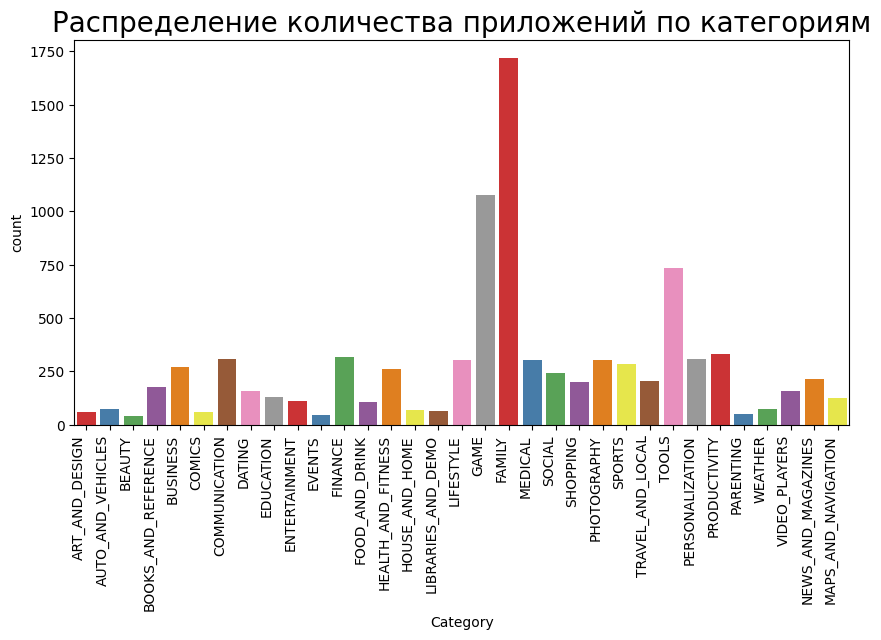

In [16]:
fig = plt.figure(figsize=(10,5))#создаем новый рисунок
g = sns.countplot(data = df, x= df['Category'], palette = "Set1")
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")

g.set_title('Распределение количества приложений по категориям', size=20)
plt.show()

 В данном графике мы наглядно видим, что наиболее популярные категории приложений это "Family" и "Game"

Рассмотрим средние рейтинги по каждой категории

In [17]:
df.groupby(by='Category')['Rating'].mean().sort_values(ascending=False)

Category
EVENTS                 4.435556
ART_AND_DESIGN         4.377049
EDUCATION              4.375969
BOOKS_AND_REFERENCE    4.347458
PERSONALIZATION        4.333117
PARENTING              4.300000
GAME                   4.281285
BEAUTY                 4.278571
HEALTH_AND_FITNESS     4.261450
SOCIAL                 4.254918
SHOPPING               4.251485
WEATHER                4.244000
SPORTS                 4.225175
PRODUCTIVITY           4.201796
FAMILY                 4.191264
AUTO_AND_VEHICLES      4.190411
PHOTOGRAPHY            4.182895
MEDICAL                4.182450
LIBRARIES_AND_DEMO     4.179688
HOUSE_AND_HOME         4.164706
FOOD_AND_DRINK         4.164151
COMICS                 4.155172
COMMUNICATION          4.151466
ENTERTAINMENT          4.136036
NEWS_AND_MAGAZINES     4.128505
FINANCE                4.127445
BUSINESS               4.102593
LIFESTYLE              4.096066
TRAVEL_AND_LOCAL       4.094146
VIDEO_PLAYERS          4.063750
MAPS_AND_NAVIGATION    4.051613

Наибольший средний рейтниг имеют приложения категории EVENTS

In [18]:
df[['App','Rating']].sort_values(by='Rating',ascending = False)

,App,Rating
10609,"Trinity Church Deltona, FL",5.0
8101,NOMISMA.com.cy by FMW,5.0
7442,Sir C J New Primary School,5.0
3957,ADS-B Driver,5.0
7435,CJ's Coffee Cafe,5.0
...,...,...
8875,DT future1 cam,1.0
7926,Tech CU Card Manager,1.0
10324,FE Mechanical Engineering Prep,1.0
6490,MbH BM,1.0


<ipython-input-19-636d98f5dcab>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(df.Rating, color="Red", shade = True)


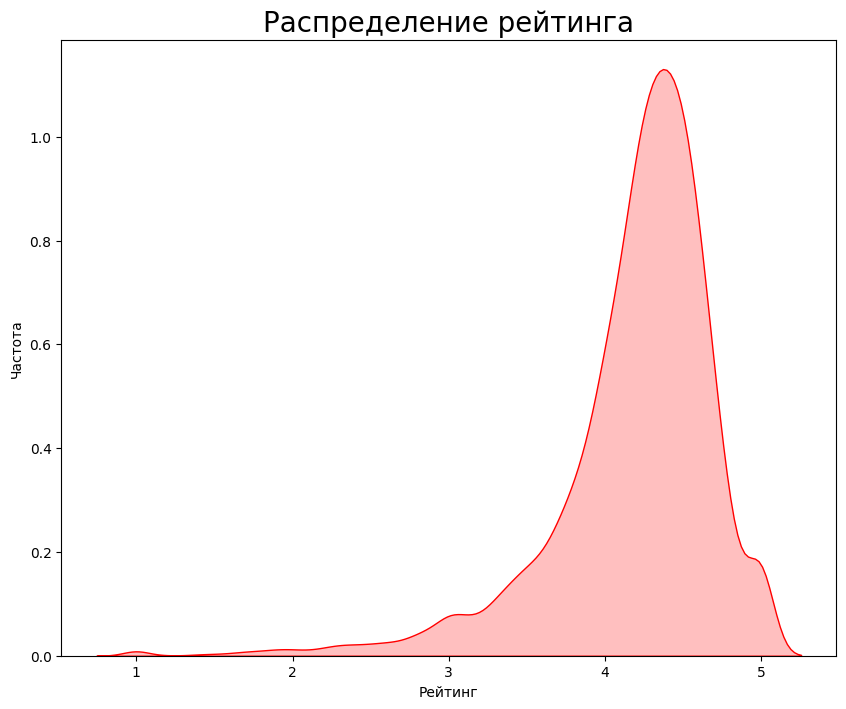

In [19]:
fig = plt.figure(figsize=(10,8))
kde = sns.kdeplot(df.Rating, color="Red", shade = True)
kde.set_xlabel("Рейтинг")
kde.set_ylabel("Частота")
plt.title('Распределение рейтинга',size = 20)
plt.show()

        Из данного графика мы видим что средний рейтинг приложений  в районе 4

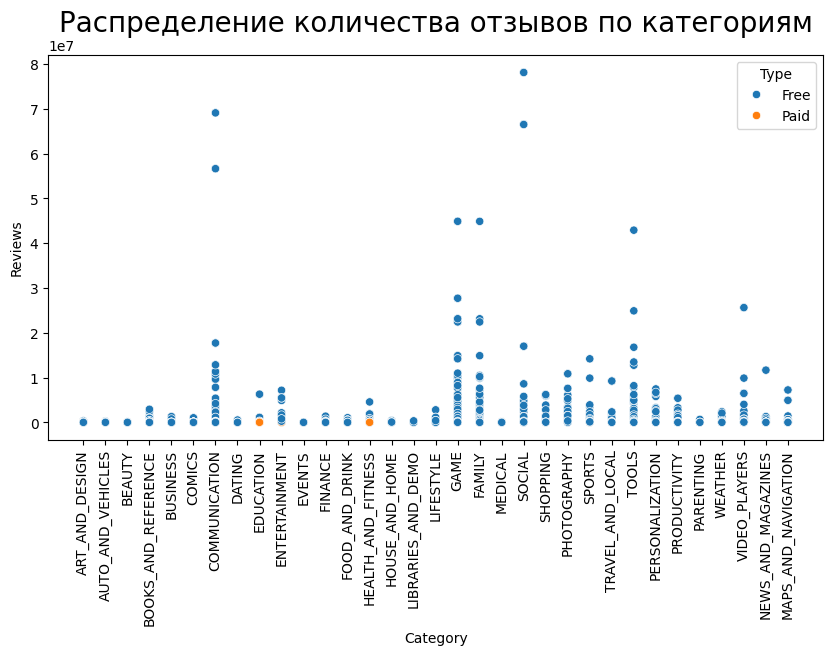

In [20]:
fig = plt.figure(figsize=(10,5))
g = sns.scatterplot(
    data = df,
    x= df['Category'],
    y= df['Reviews'],
    hue = df['Type']
    #palette = "mako"
)
plt.xticks(rotation = 90)

g.set_title('Распределение количества отзывов по категориям', size=20)
plt.show()

Наибольшее количество отзывов оставлено в категориях SOCIAL и COMMUNICATION, далее идут GAME, FAMILY. Абсолютное большинство отзывов на бесплатные прпиложения

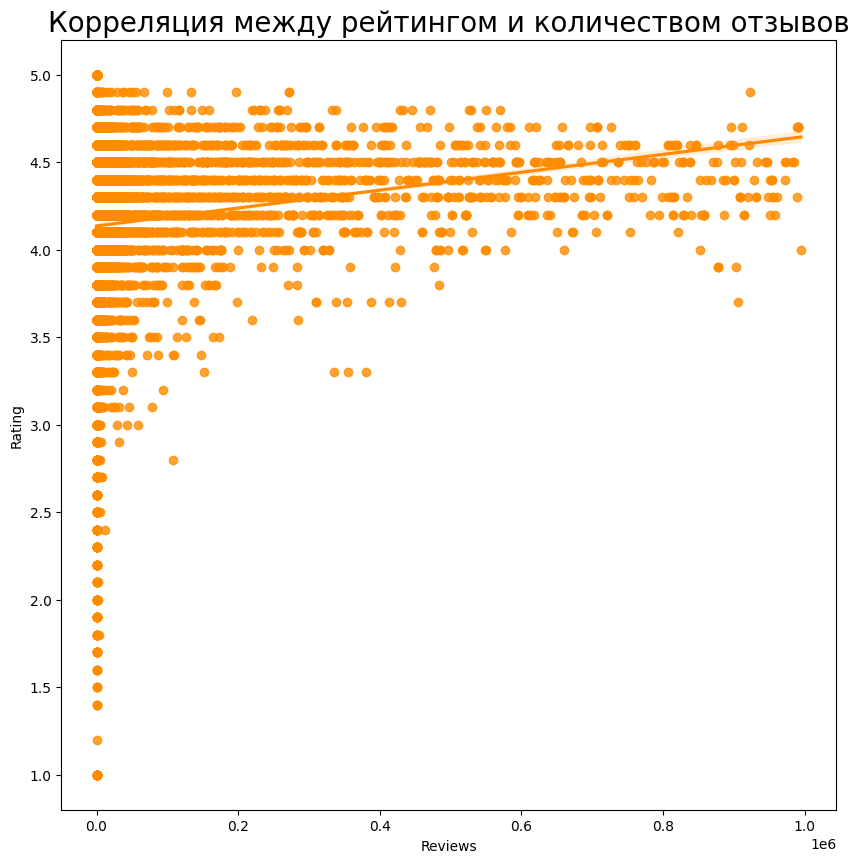

In [21]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", color = 'darkorange',data=df[df['Reviews']<1000000]);
plt.title('Корреляция между рейтингом и количеством отзывов',size = 20)
plt.show()

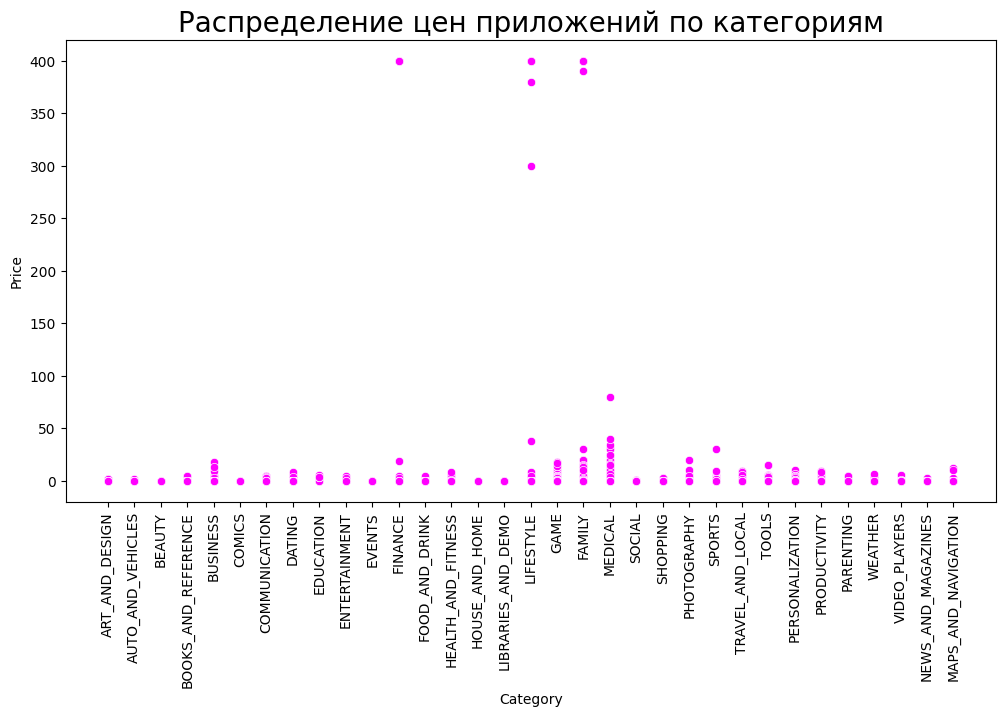

In [22]:
fig = plt.figure(figsize=(12,6))
barplot = sns.scatterplot(
    data = df,
    x = df['Category'],
    y = df['Price'],
    color = 'fuchsia'
    )
barplot.set_title('Распределение цен приложений по категориям', size=20)
plt.xticks(rotation = 90)
plt.show()

Самые высокие цены наблюдаются в категориях: FINANCE, LIFESTYLE, FAMILY, цены доходят до 400$

 Сделаем новый столбик с категориями цен


In [23]:
def price_category(price):
    if price == 0:
        return '0'
    elif price < 5:
        return '0 - 5'
    elif price < 10:
        return '5 - 10'
    elif price < 20:
        return '10 - 20'
    elif price < 40:
        return '20 - 40'
    elif price < 100:
        return '40 - 100'
    elif price < 400:
        return '100 - 400'

In [24]:
df['Price_category'] = df['Price'].apply(price_category)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Price_category
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,0
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,0


In [25]:
df.Price_category.value_counts()

0            8275
0 - 5         493
5 - 10         59
10 - 20        33
100 - 400      14
20 - 40        10
40 - 100        1
Name: Price_category, dtype: int64

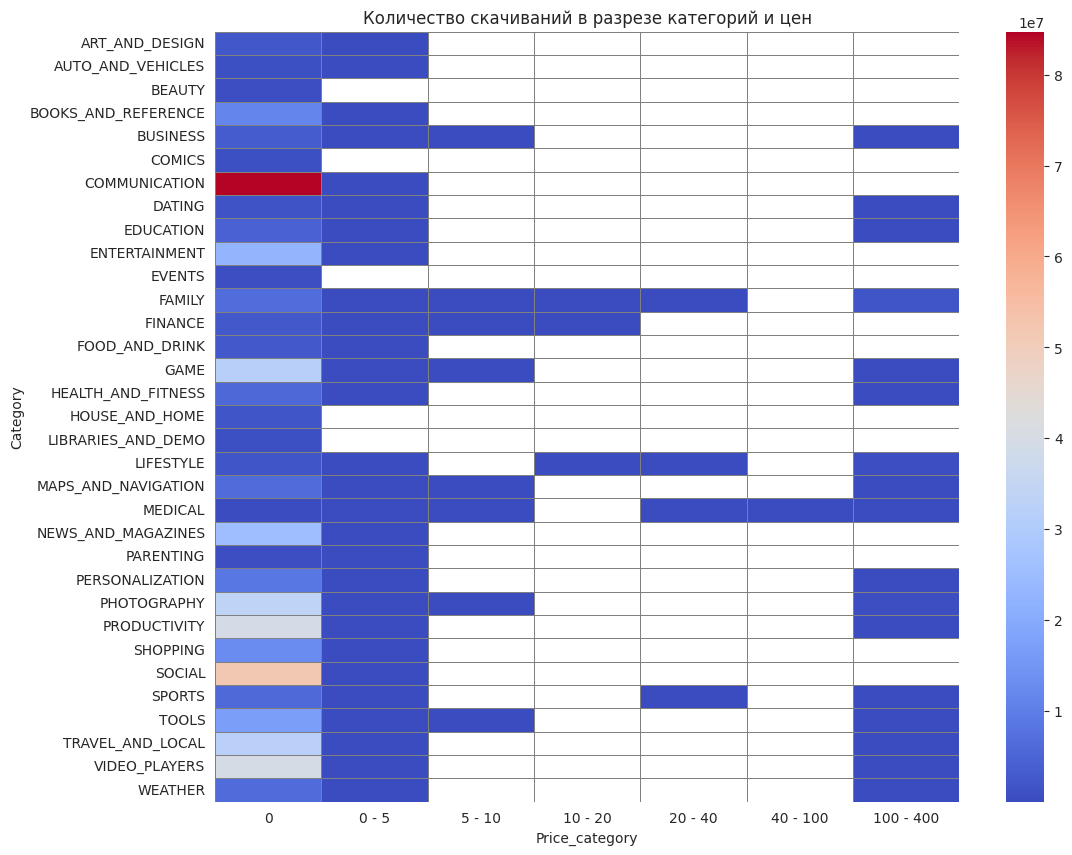

In [26]:
fig = plt.figure(figsize=(12,10))
sns.set_style('white')
pivot = df.pivot_table(
    index=["Category"],
    columns=["Price_category"],
    values="Installs",
    aggfunc=np.average)
heatmap = sns.heatmap(pivot,
            xticklabels = ['0', '0 - 5', '5 - 10', '10 - 20', '20 - 40', '40 - 100', '100 - 400'],
            cmap= "coolwarm",
            linewidths = 0.5,
            linecolor = 'grey')
heatmap.set_title('Количество скачиваний в разрезе категорий и цен')
plt.show()

 **Из этой тепловой карты мы видим, что наибольшее количество скачиваний с сильным отрывом идет по категории COMMUNICATION, при чем именно в бесплатной ценовой категории**

In [27]:
df['Rating_range'] = df['Rating'].apply(lambda x:round(x))
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Price_category,Rating_range
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,0,4
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,0,4
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,0,5
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,0,4
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,0,4


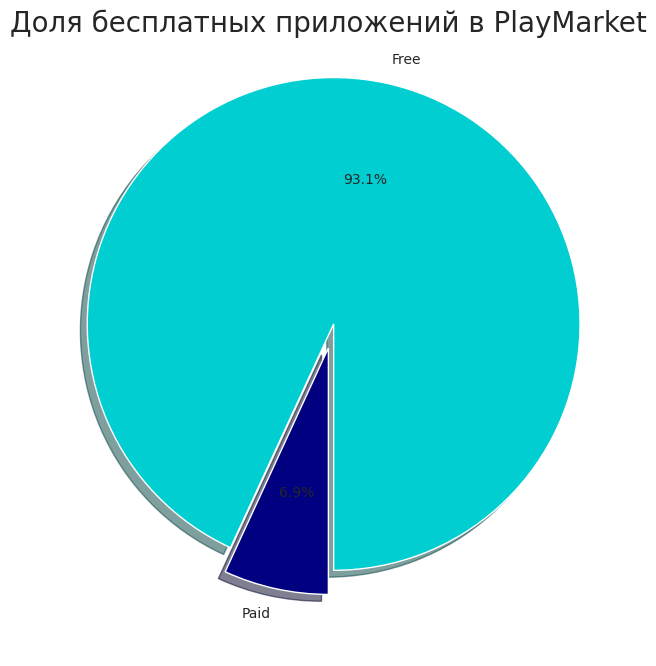

In [28]:
labels = df['Type'].value_counts(sort = True).index #
sizes = df['Type'].value_counts(sort = True)# сами значения


colors = ["darkturquoise","navy"]
explode = (0.1,0)  # explode 1st slice

fig = plt.figure(figsize=(8,8))
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=270,)

plt.title('Доля бесплатных приложений в PlayMarket',size = 20)
plt.show()

In [29]:
df['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

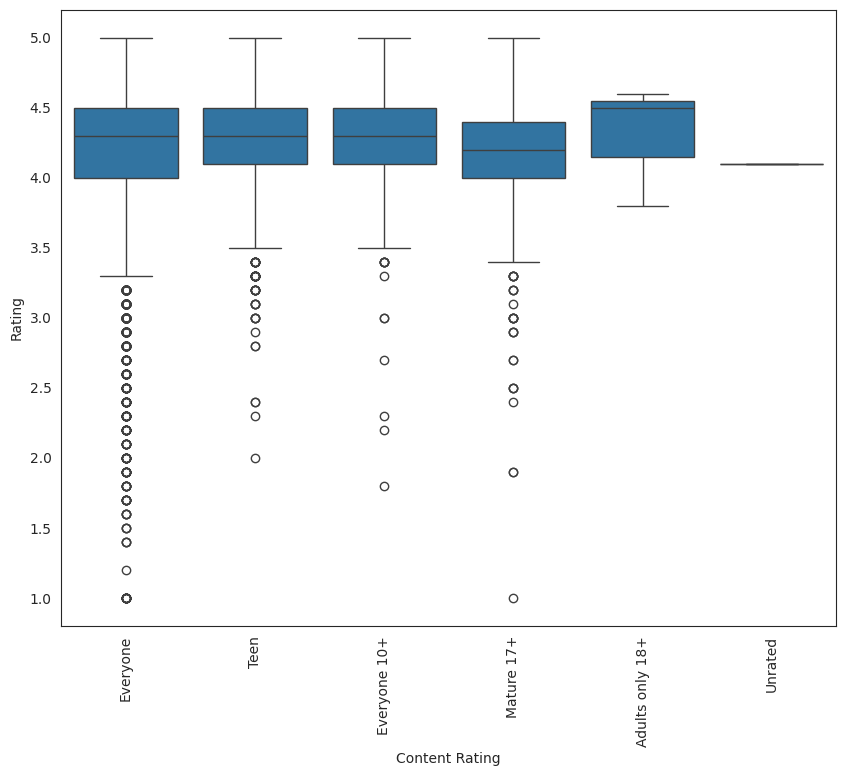

In [30]:
fig = plt.figure(figsize=(10,8))
box = sns.boxplot(data = df, x = 'Content Rating', y = 'Rating')
plt.xticks(rotation = 90)
plt.show()


В

In [31]:
df[df['Content Rating']=='Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Price_category,Rating_range
8266,DC Universe Online Map,TOOLS,4.1,1186,6.4M,50000,Free,0.0,Unrated,Tools,"February 27, 2012",1.3,2.3.3 and up,0,4


Так как в данной категории контента у нас только одна запись , удалим ее

In [32]:
df = df[df['Content Rating']!='Unrated']